We aim to solve the Lighthill-Withams-Richards PDE: u_t+u(1-u)_x = 0 on the domain x,t \in [0,2pi]x[0,3] with periodic boundary conditions.

Initial condition is a cubic spline interpolating 4 points u,x \in  [0.2,0.9]x[0,2pi]. The standard numerical solver (finite volume scheme) is used to solve for the solution.

Having solved numerically for 8 representative IC's, we import numerical solution to the problem in the form of LWRData-init-xval-tval.mat, an array whose i,j,k-th entry is the solution for (training) initial condition i, at x-value j, and time step k.

Here: 
0<i<8, indexes initial condition
0<j<512 indexes x-value with x_0=0.0123, x_511 = 2pi
0<k<513 indexes t-step with t_0 = 0, t_512 = 3

We aim to train a neural network to take input = u(t_n) (the solution at time n*\delta_t) and predict the solution u(t_{n+1}), (the solution at time (n+1)*\delta_t).

the network architecture is hence 512>(512>512>512)>512, where the intermediary layers have activation function tanh.

for testing, we generate 8 new IC's, solve with the numerical solver and the model independently, then compare.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters 
input_size = 512 # u(<x>,t_i)
hidden_size = 512 #number of neurons in each hidden layer
n_layers = 3  #number of hidden layers
output_size = 512
num_epochs = 20
learning_rate = 0.0001
tmax= 3  #the maximum time forward which we predict , at the end we want tmax=5.
dx = 2*np.pi/512
M = 513 #time steps
N = 512 #spacial points

In [78]:
# Define the neural network class
class TimeStepper(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super(TimeStepper, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size

# Create a list of hidden layers with Xavier initialization
        layers = []
        for _ in range(self.n_layers):
            linear_layer = nn.Linear(self.input_size, self.hidden_size)
            init.xavier_uniform_(linear_layer.weight)  # Xavier initialization
            layers.append(linear_layer)
            layers.append(nn.Tanh()) #sub as needed
            #layers.append(nn.ReLU()) #sub as needed
            #layers.append(nn.LeakyReLU()) #sub as needed
            self.input_size = self.hidden_size  # Update input size for the next layer

        self.hidden_layers = nn.Sequential(*layers)

        # Output layer with Xavier initialization
        self.fc_out = nn.Linear(self.hidden_size, self.output_size)
        init.xavier_uniform_(self.fc_out.weight)  # Xavier initialization

    def forward(self, x):
        # Forward pass
        x = self.hidden_layers(x)
        x = self.fc_out(x)
        return x



In [79]:
#Load the data
Dictdata = scipy.io.loadmat('C:/Users/thoma/Downloads/LWRData-init-xval-tval.mat')
Data = Dictdata['Data']
inputs = np.ndarray((4096,512)) #nth row contains a solution at time t
target_outputs = np.ndarray((4096,512)) #nth row contains corresponding solution at time t+1
index = 0
for i in range(0,8):
    for k in range(1,513):
        inputs[index] = Data[i,:,k-1]
        target_outputs[index] = Data[i,:,k]
        index = index+1

inputs = torch.tensor(inputs,dtype=torch.float32, requires_grad=True).to(device) 
target_outputs = torch.tensor(target_outputs,dtype=torch.float32, requires_grad=True).to(device)

batch_size = 64
dataset = TensorDataset(inputs, target_outputs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [80]:
# Create an instance of the neural network
net = TimeStepper(input_size, hidden_size, n_layers, output_size).to(device)

# Define the loss function (replace with your actual loss function)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

num_epochs = 400

for epoch in range(num_epochs):
    for batch_input, batch_output in dataloader:
        # Move batch data to the GPU
        batch_input, batch_output = batch_input.to(device), batch_output.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        predictions = net(batch_input)

        # Compute the loss
        loss = criterion(predictions, batch_output)

        # Backpropagation and optimization
        
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    if (epoch+1)%50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Optionally, save the trained model
#torch.save(net.state_dict(), 'my_model.pth')

Epoch [10/400], Loss: 0.0005868618027307093
Epoch [20/400], Loss: 0.0001813972630770877
Epoch [30/400], Loss: 0.00011807489499915391
Epoch [40/400], Loss: 5.223943298915401e-05
Epoch [50/400], Loss: 5.113612496643327e-05
Epoch [60/400], Loss: 3.422411100473255e-05
Epoch [70/400], Loss: 3.1920459150569513e-05
Epoch [80/400], Loss: 3.012286833836697e-05
Epoch [90/400], Loss: 2.5896184524754062e-05
Epoch [100/400], Loss: 3.2536350772716105e-05
Epoch [110/400], Loss: 2.5770486900000833e-05
Epoch [120/400], Loss: 9.679853974375874e-06
Epoch [130/400], Loss: 1.196603352582315e-05
Epoch [140/400], Loss: 1.2704085747827776e-05
Epoch [150/400], Loss: 3.493147232802585e-05
Epoch [160/400], Loss: 1.151349442807259e-05
Epoch [170/400], Loss: 1.5427764083142392e-05
Epoch [180/400], Loss: 8.529530532541685e-06
Epoch [190/400], Loss: 7.280608770088293e-06
Epoch [200/400], Loss: 8.625837836007122e-06
Epoch [210/400], Loss: 7.900769560365006e-06
Epoch [220/400], Loss: 8.710077963769436e-06
Epoch [230/4

In [88]:
#Final predictions for training data...
predictions = net(inputs).to('cpu').detach().numpy()
#Load the TEST data (consists of 8 unseen solutions)
tDictdata = scipy.io.loadmat('C:/Users/thoma/Downloads/LWRData-init-xval-tvalTEST.mat')
tData = tDictdata['Data']
tinputs = np.ndarray((4096,512)) #nth row contains a solution at time t
ttarget_outputs = np.ndarray((4096,512)) #nth row contains corresponding solution at time t+1
index = 0
for i in range(0,8):
    for k in range(1,513):
        tinputs[index] = tData[i,:,k-1]
        ttarget_outputs[index] = tData[i,:,k]
        index = index+1
        
tinputs = torch.tensor(tinputs,dtype=torch.float32, requires_grad=True).to(device) 
ttarget_outputs = torch.tensor(ttarget_outputs,dtype=torch.float32, requires_grad=True).to(device)
#Final predictions for the test data
tpredictions = net(tinputs).to('cpu').detach().numpy()

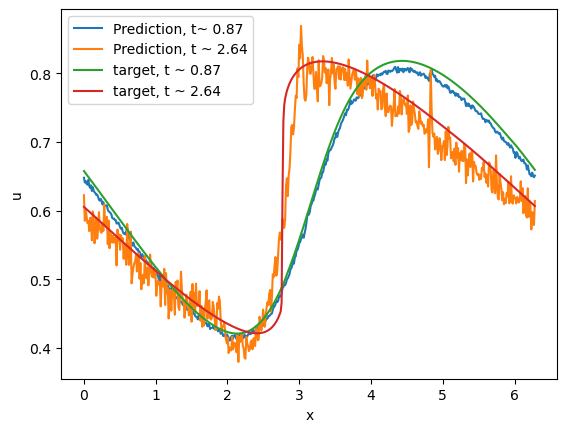

In [122]:
# Create a plot
x_values = np.linspace(0, 2 * np.pi, len(tpredictions[index1]))

plt.plot(x_values, tpredictions[2200], label='Prediction, t~ 0.87')
plt.plot(x_values, tpredictions[2500], label='Prediction, t ~ 2.64')
plt.plot(x_values, ttarget_outputs.to('cpu').detach().numpy()[2200], label='target, t ~ 0.87')
plt.plot(x_values, ttarget_outputs.to('cpu').detach().numpy()[2500], label='target, t ~ 2.64')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

# Show the plot
plt.show()

Final notes: Clearly, there is a lot of oscillations happening, which I cannot understand yet. I have tried....
Adjust learning rate or vary the learning rate as training progresses

    did not seem to have an effect

use weight initialization (Xavier initialization)

    did not improve results

Hyperparameter tuning

    tried a variety of wider/less deep models (e.g. 10 hidden layers of 64 neurons each)
        Did not improve oscillations
    Different activation functions (ReLU, Leaky ReLU)
        Accuracy is far worse
    Increase batch size
        No discernable effect.

Fewer epochs

    Oscillations are worse

More epochs

    oscillations remain, but less pronounced

L2 regularization (add penalty for large weights)

    This greatly diminished the oscillations, at the cost of model accuracy
